# Data preparation

## Import libraries

In [1]:
import sys, os, glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the path to the src folder to the path
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Load and crop images

We assume that the "Qflow2.0" dataset are stored in the `data/raw/` directory. The link to the dataset is provided in the `data/external` folder.
We also assume that you want to only train a model for state regime detection on the "Qflow2.0" dataset(the sim_normal data is for that).
This cell is supposed to be run only once if save_data is set to True.
The cropped images are stored in the `data/interim/` directory.

In [2]:
# from ml_tools.data.subimage_generator import SubImageGenerator

# # Set up the path to the data
# data_path = '../data/raw/data_qflow_v2/simulated/sim_normal/'
# data_files = glob.glob(data_path + '*.hdf5')

# for raw_data_file in data_files:
#     generator = SubImageGenerator(border_margin=20)

#     cropped_data = generator.generate_multiple_sub_images(
#         raw_data_file, save_images=True, return_images=False)

    


## Load subimages and create a dataset for training
The current step we need to do is data preparation. We need to load the subimages, make the preleminary modifications and create a dataset for training and testing. For that we will use an instance of the DatasetPreparation class. We need to specify here what type of label we want. Options are 'state' or 'data_quality' depending on what we want to train the model for. If we want to save the dataset you need to specify the path where you want to save it(it should be in data/interim/).You can specify a single .npz file,a whole directory(you must set the flag use_all_data) or the whole dataset in dictonary form from the cell above.


In [3]:
# from ml_tools.preprocessing.dataset_preparator import DatasetPreparator

# subimage_folder_path = '../data/interim/data_qflow_v2/simulated/sim_normal/'

# preparator = DatasetPreparator(seed=42)

# train_data, train_labels, test_data, test_labels = preparator.prepare_dataset(
#                         path_or_dict=subimage_folder_path,
#                         save_path="../data/interim/data_qflow_v2/simulated/",
#                         train_test_split=0.8, 
#                         label_key_name='state', 
#                         )

Plot a few images to check if everything is ok

In [4]:
# # Plot a few images to check if everything is ok
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# ax[0].imshow(train_data[0, :, :, 0])
# ax[1].imshow(train_data[1, :, :, 0])
# ax[2].imshow(train_data[2, :, :, 0])
# plt.show()


## Preprocess the data
Now that we have the dataset created we need to preprocess it. For that we will use an instance of the SubImagePreprocessor class. The preprocessed dataset should be saved in the data/processed/ directory.

In [5]:
from ml_tools.preprocessing.subimage_preprocessor import SubImagePreprocessor


# Define the path to the dataset
dataset_path = '../data/interim/data_qflow_v2/simulated/unprocessed_dataset/'

# Load training data and labels
train_data_path = dataset_path + 'training/training_data.npz'
train_labels_path = dataset_path + 'training/training_labels.npz'
evaluation_data_path = dataset_path + 'testing/evaluation_data.npz'
evaluation_labels_path = dataset_path + 'testing/evaluation_labels.npz'

train_data = np.load(train_data_path)['training_data']
train_labels = np.load(train_labels_path)['training_labels']
evaluation_data = np.load(evaluation_data_path)['evaluation_data']
evaluation_labels = np.load(evaluation_labels_path)['evaluation_labels']
	
preprocessor = SubImagePreprocessor(
    auto_invert=False,
    noise_reduction=[],
    clip_value=None,
    cutoff_value= None
)

save_path = '../data/processed/data_qflow_v2/simulated/'

processed_train_data = preprocessor.preprocess_subimages(train_data,train_or_test='train',save_path=save_path)
processed_evaluation_data = preprocessor.preprocess_subimages(evaluation_data,train_or_test='test',save_path=save_path)


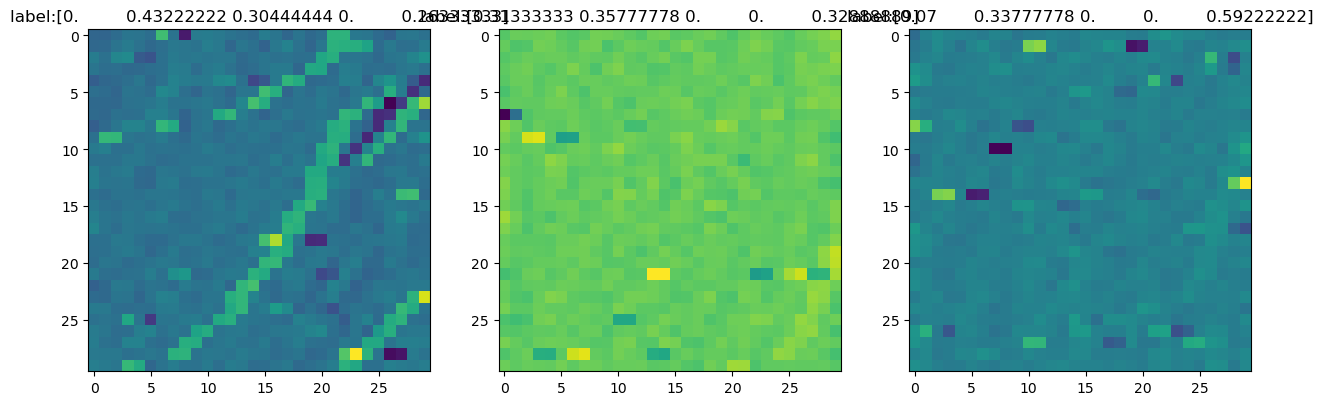

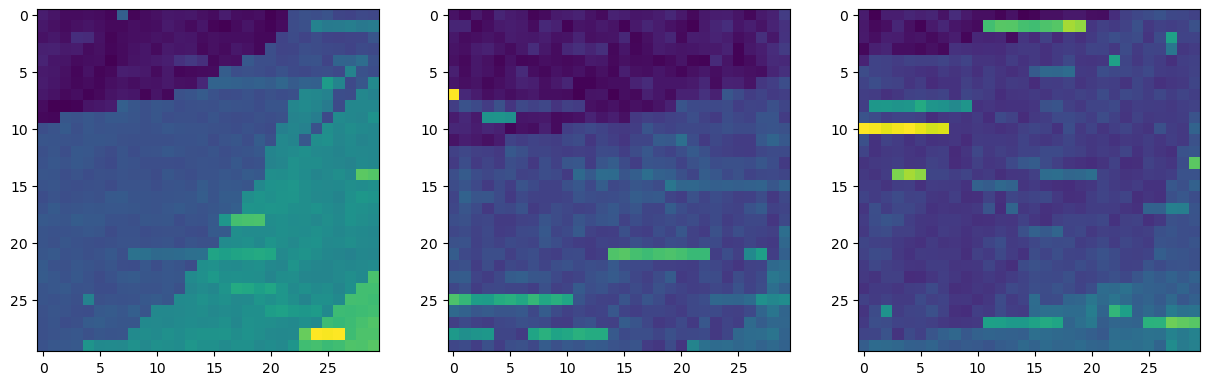

In [6]:
# Plot a few images at random
# Generate 3 random index
random_idx = np.random.randint(0, train_data.shape[0], 3)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].set_title('label:'+str(train_labels[random_idx[0]]))
ax[1].set_title('label:'+str(train_labels[random_idx[1]]))
ax[2].set_title('label:'+str(train_labels[random_idx[2]]))
ax[0].imshow(processed_train_data[random_idx[0], :, :, 0])
ax[1].imshow(processed_train_data[random_idx[1], :, :, 0])
ax[2].imshow(processed_train_data[random_idx[2], :, :, 0])
# Plot the original images 
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(train_data[random_idx[0], :, :, 0])
ax[1].imshow(train_data[random_idx[1], :, :, 0])
ax[2].imshow(train_data[random_idx[2], :, :, 0])
# Plot the labels as titles 
plt.show()